In [5]:
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from ucimlrepo import fetch_ucirepo  # Ensure this package is installed
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


In [6]:
# Fetch dataset
heart_disease = fetch_ucirepo(id=45)

# Data (as pandas DataFrames)
X = heart_disease.data.features
y = heart_disease.data.targets

# Combine features and target
df = pd.concat([X, y], axis=1)

# Assign column names
column_names = [
    'age', 'sex', 'cp', 'trestbps', 'chol', 'fbs',
    'restecg', 'thalach', 'exang', 'oldpeak',
    'slope', 'ca', 'thal', 'num'
]
df.columns = column_names

# Handle Missing Values
df.replace(['?', ''], np.nan, inplace=True)
df = df.apply(pd.to_numeric, errors='coerce')
print(df.isnull().sum())

# Fill missing numerical values with median
for col in ['ca', 'thal', 'oldpeak', 'slope']:
    df[col].fillna(df[col].median(), inplace=True)

# Simplify 'num' to binary classification
df['target'] = df['num'].apply(lambda x: 1 if x > 0 else 0)
df.drop('num', axis=1, inplace=True)

# Convert 'ca' and 'thal' to integer type before encoding
df['ca'] = df['ca'].astype(int)
df['thal'] = df['thal'].astype(int)

# One-Hot Encoding for categorical variables
categorical_cols = ['cp', 'restecg', 'slope', 'thal', 'ca']
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# Separate features and target variable
X = df.drop('target', axis=1).values
y = df['target'].values

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

# Feature scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          4
thal        2
num         0
dtype: int64


In [ ]:
class HeartDiseaseDataset(Dataset):
    def __init__(self, features, targets):
        self.X = torch.tensor(features, dtype=torch.float32)
        self.y = torch.tensor(targets, dtype=torch.float32)  # Binary classification
    
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


In [8]:
# Create datasets
train_dataset = HeartDiseaseDataset(X_train, y_train)
test_dataset = HeartDiseaseDataset(X_test, y_test)

# Create data loaders
batch_size = 16
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size)


In [9]:
class HeartDiseaseModel(nn.Module):
    def __init__(self, input_dim):
        super(HeartDiseaseModel, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(32, 1),
            nn.Sigmoid()  # For binary classification
        )
        
    def forward(self, x):
        return self.network(x)


In [10]:
input_dim = X_train.shape[1]
model = HeartDiseaseModel(input_dim)

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [11]:
num_epochs = 100
patience = 10  # For early stopping
best_loss = np.inf
counter = 0
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch).view(-1)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * X_batch.size(0)
    epoch_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_loss)
    
    # Validation phase
    model.eval()
    with torch.no_grad():
        val_outputs = model(torch.tensor(X_test, dtype=torch.float32)).view(-1)
        val_loss = criterion(val_outputs, torch.tensor(y_test, dtype=torch.float32)).item()
        val_losses.append(val_loss)
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}")
    
    # Early stopping
    if val_loss < best_loss:
        best_loss = val_loss
        counter = 0
        best_model_state = model.state_dict()
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered")
            break

# Load the best model
model.load_state_dict(best_model_state)


Epoch [1/100], Train Loss: 0.6920, Val Loss: 0.6746
Epoch [2/100], Train Loss: 0.6554, Val Loss: 0.6374
Epoch [3/100], Train Loss: 0.6320, Val Loss: 0.5959
Epoch [4/100], Train Loss: 0.5834, Val Loss: 0.5460
Epoch [5/100], Train Loss: 0.5557, Val Loss: 0.4916
Epoch [6/100], Train Loss: 0.5238, Val Loss: 0.4396
Epoch [7/100], Train Loss: 0.4962, Val Loss: 0.3918
Epoch [8/100], Train Loss: 0.4790, Val Loss: 0.3633
Epoch [9/100], Train Loss: 0.4865, Val Loss: 0.3478
Epoch [10/100], Train Loss: 0.4225, Val Loss: 0.3310
Epoch [11/100], Train Loss: 0.4128, Val Loss: 0.3117
Epoch [12/100], Train Loss: 0.3952, Val Loss: 0.3022
Epoch [13/100], Train Loss: 0.3963, Val Loss: 0.3000
Epoch [14/100], Train Loss: 0.3824, Val Loss: 0.2951
Epoch [15/100], Train Loss: 0.3614, Val Loss: 0.2949
Epoch [16/100], Train Loss: 0.3992, Val Loss: 0.2936
Epoch [17/100], Train Loss: 0.4157, Val Loss: 0.2946
Epoch [18/100], Train Loss: 0.3640, Val Loss: 0.2926
Epoch [19/100], Train Loss: 0.3680, Val Loss: 0.2937
Ep

<All keys matched successfully>

              precision    recall  f1-score   support

           0       0.87      0.82      0.84        33
           1       0.80      0.86      0.83        28

    accuracy                           0.84        61
   macro avg       0.84      0.84      0.84        61
weighted avg       0.84      0.84      0.84        61



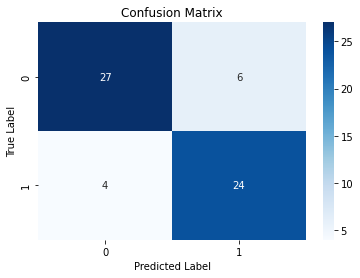

In [12]:
model.eval()
with torch.no_grad():
    y_pred_prob = model(torch.tensor(X_test, dtype=torch.float32)).view(-1).numpy()
    y_pred = (y_pred_prob > 0.5).astype(int)

# Classification report
print(classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


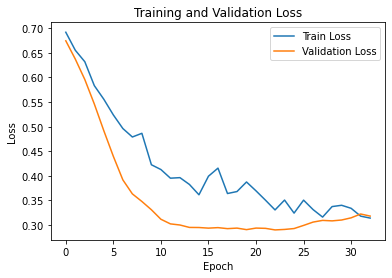

In [13]:
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()
